# Source Localization using Distributed Sensors (Focus on one Sensor)
 **(End goal is wireless distributed source localization)**

The first thing I need is a position matrix for all the sensors. The reason to start from a position matrix and not a distance matrix is because this algorithm can be adapted to a scenario where the sensors are not in a static position. I will record those positions in a dictionary using as relative position the position of sensor 1.

In [1]:
%%html
<img src="sensors.jpg" alt="Drawing" style="width: 500px;" align= "middle">

## Location of the Test Points in inches:
 * Point 1: (2, 6)
 * Point 2: (4, 6)
 * Point 3: (2, 2)
 * Point 4: (4, 2)

In [2]:
import numpy as np
import scipy
from matplotlib import pyplot
from scipy import signal
from scipy.stats import norm
from sympy import *
from collections import deque
import random
import scipy.sparse.linalg as splinalg

## Location of the Sensors:

In [3]:
def R_dictionary(sensor, Hash):
    Hash.update(sensor)

#Growing my Position dictionary:
Hash={}
k=0
for j in np.array([0, 15, 30, 45]):
    for i in np.array([0, 10, 20]):
        k=k+1
        R_dictionary({k: [j, i]}, Hash)
print(Hash)

{1: [0, 0], 2: [0, 10], 3: [0, 20], 4: [15, 0], 5: [15, 10], 6: [15, 20], 7: [30, 0], 8: [30, 10], 9: [30, 20], 10: [45, 0], 11: [45, 10], 12: [45, 20]}


Now, I want to create a relative distance matrix by computing the Euclidean distance between each sensor. 

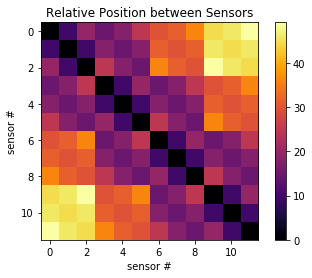

In [4]:
Rel_Pos= np.zeros((len(Hash), len(Hash)))
for i in  np.arange(len(Hash)):
    for j in np.arange(len(Hash)):
        Rel_Pos[i][j]= ((Hash[i+1][0] - Hash[j+1][0])**2 + (Hash[i+1][1] - Hash[j+1][1])**2)**(1./2.)
pyplot.imshow(Rel_Pos, cmap= 'inferno')
pyplot.colorbar()
pyplot.xlabel('sensor #')
pyplot.ylabel('sensor #')
pyplot.title('Relative Position between Sensors')
pyplot.show()

**Triangulation Method** 

A common way to localize sources is using a method called the Triangulation Method. This means that one sensor communicates to two other sensors in order to localize where the source of the wave came from. The main Equation to be solved here takes the following form:

\begin{equation}
E(x_0, y_0)= 2(x_0^2+y_0^2-x_0x_2-x_0x_3-y_0y_2-y_0y_3) + x_2^2+x_3^2+y_2^2+y_3^2 - (r_{21}^2+r_{31}^2)(x_0^2+y_0^2-2(x_0x_1+y_0y_1)+x_1^2+y_1^2))^2
\end{equation}

From this expression, the following results through further derivation: First, we make an expression for the distances between the vertices of the triangle and the impact point:

\begin{equation}
    d_i= ((x_i-x_0)^2+(y_i-y_0)^2)^{\frac{1}{2}}
\end{equation}

Then, the following expression is derived from the previous one which I call FFF1 in the code:

\begin{equation}
E(x_0, y_0)= (t_{23}(d_1-d_2)-t_{12}(d_2-d_3))^2+(t_{31}(d_2-d_3)-t_{23}(d_3-d_1))^2+(t_{12}(d_3-d_1)-t_{31}(d_1-d_2))^2
\end{equation}

Since I only have one equation and two unknowns and my intention is to use Newton Krylov with GMRES for optimization, I need two equations. However, it is common practice to start such optimization by stating:

\begin{equation}
f(x_0, y_0)=0
\end{equation}

\begin{equation}
\frac{\partial f(x_0,y_0)}{\partial x_0}=0
\end{equation}
and 
\begin{equation}
\frac{\partial f(x_0,y_0)}{\partial y_0}=0
\end{equation}

This way I begin with a two equation two unknowns as seen in F1, whose Jacobian now becomes the Hessian of FFF1, and I called it J1 in the code.

In [5]:
def Event(sensor, right, time, timelast):
    ###############################################################
    # MODULE FOR ANOMALY DETECTION
    # -------------------------------------------------------------
    # At the moment, I will be using a Discrete Wavelet Transform for this 
    # module using the Fast Wavelet Transform Algorithm to detect events. 
    # I only care about the level 1 decomposition's second coefficient (d1) in  s= a1+d1
    # to identify whether there is an event or not. As the project develops, this module 
    # will detect events using Dana's method
    ###############################################################
    timelast=timelast
    timenow=time[-1]
    widths = np.arange(1, 31)
    sensor= np.array(sensor)
    cwtmatr = signal.cwt(sensor.astype(int), signal.ricker, widths)
    
    yesno=0
    left=right
    right = np.linalg.norm(cwtmatr[:, -1], np.inf)
    
    if right-left > 250 and np.abs(timenow-timelast)>2000:
        yesno = 1 
        timelast= timenow
        sensdata= sensor[-1]   
    else:
        yesno = 0
        sensdata = np.zeros_like(right)

    return yesno, right, sensdata, timelast

In [6]:
# TRIANGULARIZATION STATEMENT EXPRESSION
def FFF1(x1, x2, x3, y1, y2, y3, t23, t12, t31, x0,y0):
    d1= ((x1-x0)**2+(y1-y0)**2)**(1./2.)
    d2= ((x2-x0)**2+(y2-y0)**2)**(1./2.)
    d3= ((x3-x0)**2+(y3-y0)**2)**(1./2.)
    return t23*(d1-d2)-t12*(d2-d3)**2+(t31*(d2-d3)-t23*(d3-d1))**2+(t12*(d3-d1)-t31*(d1-d2))**2

# EXPRESSION TO OPTIMIZE(DX and DY DERIVATIVES OF EXPRESSION ABOVE)
def F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u):
    x0= Symbol('x0')
    y0= Symbol('y0')
    dFdx = (FFF1(x1, x2, x3, y1, y2, y3, t23, t12, t31, x0,y0)).diff(x0)
    dFdy = (FFF1(x1, x2, x3, y1, y2, y3, t23, t12, t31, x0,y0)).diff(y0)
    
    dx= lambdify((x0,y0),dFdx)
    dy= lambdify((x0,y0),dFdy)
    return np.array([dx(u[0],u[1]),dy(u[0],u[1])])

# JACOBIAN OF THE EXPRESSION TO OPTIMIZE (HESSIAN OF FFF1)
def J1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u):
    x0= Symbol('x0')
    y0= Symbol('y0')
    dFdx = FFF1(x1, x2, x3, y1, y2, y3, t23, t12, t31,x0,y0).diff(x0)
    dFdy = FFF1(x1, x2, x3, y1, y2, y3, t23, t12, t31, x0,y0).diff(y0)
    
    ddFdx= dFdx.diff(x0)
    ddFdy= dFdx.diff(y0)
    ddFxdy= dFdx.diff(y0)
    ddFydx= dFdy.diff(x0)
    
    dxx= lambdify((x0,y0),ddFdx)
    dyy= lambdify((x0,y0),ddFdy)
    dxy= lambdify((x0,y0),ddFxdy)
    dyx= lambdify((x0,y0),ddFydx)
    
    return np.array([[dxx(u[0],u[1]), dxy(u[0],u[1])],
                     [dyx(u[0],u[1]), dyy(u[0],u[1])]])

In [7]:
def SourceLoc(s1,s2,s3,u,x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol,maxit,epsilon,verbose):
    ###################################################################
    # MODULE FOR SOURCE LOCALIZATION (using Newton-Krylov)
    # -----------------------------------------------------------------
    # This is my version of fsolve_newton() originally developed by Jed 
    # Brown (https://github.com/cucs-numpde/class). This is the routine
    #  that will do the source localization given three sensor signals
    ###################################################################
    u0= u.copy()
    Fu= F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u)
    JJ= J1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u)
    
    norm0= np.linalg.norm(Fu)
    enorm_last= np.linalg.norm(u - np.array([1,1],dtype= np.float64))
    
    for i in range(maxit):
        
        def Ju_fd(v): # Preconditioning the Jacobian using Krylov 
            return (F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u + epsilon*v)  - 
                    Fu) / epsilon
    
        Ju = splinalg.LinearOperator((len(Fu),len(u)), matvec=Ju_fd)
    
        du, info = splinalg.gmres(JJ, Fu, x0=u, tol=1e-5, restart=10)
        
        if info != 0:
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        
        u -= du

        Fu= F1(x1, x2, x3, y1, y2, y3, t23, t12, t31, u)
        norm= np.linalg.norm(Fu)
        
        if verbose:
            enorm= np.linalg.norm(u - np.array([1,1]))
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e} eratio {:6.2f}'.
                  format(i+1, norm, norm/norm0, enorm/enorm_last**2))
            enorm_last= enorm
        if norm < rtol*norm0:
            break
        if np.isnan(norm):
            raise RuntimeError('Newton Raphson failed to converge: {:d}'.format(info)) 
    return u,i   

In [8]:
def Breeding(all_sensors, n):
    ###########################################################################
    # MODULE FOR RANDOMLY SAMPLING THE SENSORS TO BE USED
    #--------------------------------------------------------------------------
    # This function will be called by each sensor every time there is an event in 
    # order to be paired with two of the fittest sensors to make the guess of the
    # source localization.
    ###########################################################################
   
    listing= np.arange(len(all_sensors))
    listing= np.delete(listing, n)
    
    fitness= np.array(all_sensors)
    fitness= np.delete(fitness, n)
    
    fitness= fitness.astype(np.float) #I will put that fitness into a probability density function
    while np.count_nonzero(fitness)==1:
        fitness[np.random.randint(1, fitness.shape[0])]= 10.0
    p=fitness/sum(fitness)
    
    pair= np.random.choice(listing,2, replace=False, p = p) 
    
    return pair 

sensor 1 detected an event
sensor 2 detected an event
sensor 3 detected an event
sensor 4 detected an event
sensor 5 detected an event
sensor 6 detected an event
[-2.91634641  5.46151401] L2 error=  4.94574859259 Max dist error=  4.91634640537
sensor 1 detected an event
sensor 3 detected an event
sensor 4 detected an event
sensor 5 detected an event
[ 4.19344211  8.37405619] L2 error=  3.23223313996 Max dist error=  2.37405619173
sensor 1 detected an event
sensor 3 detected an event
sensor 4 detected an event
sensor 5 detected an event
[ 2.08536603  8.15312255] L2 error=  2.15481416544 Max dist error=  2.15312255324
sensor 1 detected an event
sensor 3 detected an event
sensor 4 detected an event
sensor 5 detected an event
[ 3.92311769  7.12501684] L2 error=  2.22801358648 Max dist error=  1.92311769007
sensor 1 detected an event
sensor 2 detected an event
sensor 3 detected an event
sensor 4 detected an event
sensor 5 detected an event
[ 1.7534509   9.04317016] L2 error=  3.05314118073 

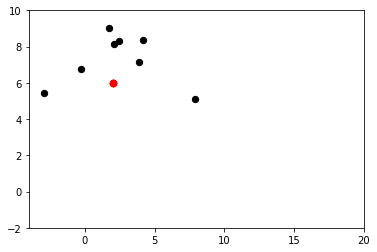

In [17]:
f= 'Data1st.txt' #just importing data from touch in a single point with different forces
# This dataset has the peculiarity that I only touched the same spot ten times, therefore, my estimations should
# be close to those coordinates.
distance_tolerance=15
window_size= 1000
sampling_frequency= 400 #Hz
Window1= deque([])
Window2= deque([])
Window3= deque([])
Window4= deque([])
Window5= deque([])
Window6= deque([])
AllS1= deque([])
TimeWindow=deque([])
timelast1=0
timelast2=0
timelast3= 0
timelast4=0
timelast5=0
timelast6= 0
j=0

# The sampling rate at which this data was taken is 400 Hz and the goal is 1kHz
right1=0
right2=0
right3=0
right4=0
right5=0
right6=0

with open(f) as file: #this loop will be replaced by some pyserial readline instruction if a life demo were to be done
    for line in file:
        data, timestamp = line.split("-")
        Sensors= data.split(",")

        #One deque per sensor plus one for the timestamps.
        Sensors1=Sensors[0]
        Sensors2=Sensors[1]
        Sensors3=Sensors[2]
        Sensors4=Sensors[3]
        Sensors5=Sensors[4]
        Sensors6=Sensors[5]
        Time= timestamp
        AllS1.append(Sensors1)
        
        if j<=window_size:    
            Window1.append(Sensors1)
            Window2.append(Sensors2)
            Window3.append(Sensors3)
            Window4.append(Sensors4)
            Window5.append(Sensors5)
            Window6.append(Sensors6)
            TimeWindow.append(float(Time))
            j= j+1
        else:
            Window1.append(Sensors1)
            Window2.append(Sensors2)
            Window3.append(Sensors3)
            Window4.append(Sensors4)
            Window5.append(Sensors5)
            Window6.append(Sensors6)
            TimeWindow.append(float(Time))
            Window1.popleft()
            Window2.popleft()
            Window3.popleft()
            Window4.popleft()
            Window5.popleft()
            Window6.popleft()  
            TimeWindow.popleft()
            
# Now that the windows are ready, I will send them to the Event function and if most of the sensors agree
# that there is an event, then the breeding pairing will actuate
        if j>= window_size:
            
            yesno1, right1, sensdata1, timelast1= Event(Window1, right1,TimeWindow, timelast1)
            yesno2, right2, sensdata2, timelast2= Event(Window2, right2, TimeWindow, timelast2)
            yesno3, right3, sensdata3, timelast3= Event(Window3, right3, TimeWindow, timelast3)
            yesno4, right4, sensdata4, timelast4= Event(Window4, right4, TimeWindow, timelast4)
            yesno5, right5, sensdata5, timelast5= Event(Window5, right5, TimeWindow, timelast5)
            yesno6, right6, sensdata6, timelast2= Event(Window6, right6, TimeWindow, timelast6)
            
            numsens=yesno1+yesno2+yesno3+yesno4+yesno5+yesno6
            
            if numsens<4:
                continue
                
            
            sumsum=np.array([0.0,0.0])
            count=0

            if yesno1==1:
                print('sensor 1 detected an event')
                listsens= (sensdata1, sensdata2, sensdata3, sensdata4, sensdata5, sensdata6)
                listsens1= (Window1, Window2, Window3, Window4, Window5, Window6)
                pair1= Breeding(listsens, 0) #sensor1 will start at 0
                x1= Hash[1][0]
                y1= Hash[1][1]
                x2= Hash[pair1[0]+1][0]
                y2= Hash[pair1[0]+1][1]
                x3= Hash[pair1[1]+1][0]
                y3= Hash[pair1[1]+1][1]
                s1= sensdata1
                s2= listsens[pair1[0]]
                s3= listsens[pair1[1]]
                ss1= listsens1[0]
                ss2= listsens1[pair1[0]]
                ss3= listsens1[pair1[1]]
                
                t12= np.amax(np.correlate(np.asarray(ss1, dtype=np.float64),
                                          np.asarray(ss2, dtype=np.float64), mode='full'))
                t23= np.amax(np.correlate(np.asarray(ss2, dtype=np.float64),
                                          np.asarray(ss3, dtype=np.float64), mode='full'))
                t31= np.amax(np.correlate(np.asarray(ss3, dtype=np.float64),
                                          np.asarray(ss1, dtype=np.float64), mode='full'))
       
                u1,i= SourceLoc(float(s1),float(s2),float(s3),[.1,.1],
                                x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol=1e-25,maxit=50,
                               epsilon=1e-8,verbose= False)
                
                if np.linalg.norm(u1)<distance_tolerance:
                    sumsum+= u1
                    count+=1
                
            if yesno2==1:
                print('sensor 2 detected an event')
                listsens= (sensdata1, sensdata2, sensdata3, sensdata4, sensdata5, sensdata6)
                listsens1= (Window1, Window2, Window3, Window4, Window5, Window6)
                pair2= Breeding(listsens, 1) #sensor1 will start at 0
                x1= Hash[2][0]
                y1= Hash[2][1]
                x2= Hash[pair2[0]+1][0]
                y2= Hash[pair2[0]+1][1]
                x3= Hash[pair2[1]+1][0]
                y3= Hash[pair2[1]+1][1]
                s1= sensdata2
                s2= listsens[pair2[0]]
                s3= listsens[pair2[1]]
                ss1= listsens1[1]
                ss2= listsens1[pair2[0]]
                ss3= listsens1[pair2[1]]
                
                t12= np.amax(np.correlate(np.asarray(ss1, dtype=np.float64),
                                          np.asarray(ss2, dtype=np.float64), mode='full'))
                t23= np.amax(np.correlate(np.asarray(ss2, dtype=np.float64),
                                          np.asarray(ss3, dtype=np.float64), mode='full'))
                t31= np.amax(np.correlate(np.asarray(ss3, dtype=np.float64),
                                          np.asarray(ss1, dtype=np.float64), mode='full'))
       
                u2,i= SourceLoc(float(s1),float(s2),float(s3),[.1,.1],
                                x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol=1e-25,maxit=50,
                               epsilon=1e-8,verbose= False)     
                
                if np.linalg.norm(u2)<distance_tolerance:
                    sumsum+=u2
                    count+=1
                
            if yesno3==1:
                print('sensor 3 detected an event')
                listsens= (sensdata1, sensdata2, sensdata3, sensdata4, sensdata5, sensdata6)
                listsens1= (Window1, Window2, Window3, Window4, Window5, Window6)
                pair1= Breeding(listsens, 2) #sensor1 will start at 0
                x1= Hash[3][0]
                y1= Hash[3][1]
                x2= Hash[pair1[0]+1][0]
                y2= Hash[pair1[0]+1][1]
                x3= Hash[pair1[1]+1][0]
                y3= Hash[pair1[1]+1][1]
                s1= sensdata3
                s2= listsens[pair1[0]]
                s3= listsens[pair1[1]]
                ss1= listsens1[2]
                ss2= listsens1[pair1[0]]
                ss3= listsens1[pair1[1]]
                
                t12= np.amax(np.correlate(np.asarray(ss1, dtype=np.float64),
                                          np.asarray(ss2, dtype=np.float64), mode='full'))
                t23= np.amax(np.correlate(np.asarray(ss2, dtype=np.float64),
                                          np.asarray(ss3, dtype=np.float64), mode='full'))
                t31= np.amax(np.correlate(np.asarray(ss3, dtype=np.float64),
                                          np.asarray(ss1, dtype=np.float64), mode='full'))
       
                u3,i= SourceLoc(float(s1),float(s2),float(s3),[.1,.1],
                                x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol=1e-25,maxit=50,
                               epsilon=1e-8,verbose= False)
                if np.linalg.norm(u3)<distance_tolerance:
                    sumsum+=u3
                    count+=1
        
            if yesno4==1:
                print('sensor 4 detected an event')
                listsens= (sensdata1, sensdata2, sensdata3, sensdata4, sensdata5, sensdata6)
                listsens1= (Window1, Window2, Window3, Window4, Window5, Window6)
                pair1= Breeding(listsens, 3) #sensor1 will start at 0
                x1= Hash[4][0]
                y1= Hash[4][1]
                x2= Hash[pair1[0]+1][0]
                y2= Hash[pair1[0]+1][1]
                x3= Hash[pair1[1]+1][0]
                y3= Hash[pair1[1]+1][1]
                s1= sensdata4
                s2= listsens[pair1[0]]
                s3= listsens[pair1[1]]
                ss1= listsens1[3]
                ss2= listsens1[pair1[0]]
                ss3= listsens1[pair1[1]]
                
                t12= np.amax(np.correlate(np.asarray(ss1, dtype=np.float64),
                                          np.asarray(ss2, dtype=np.float64), mode='full'))
                t23= np.amax(np.correlate(np.asarray(ss2, dtype=np.float64),
                                          np.asarray(ss3, dtype=np.float64), mode='full'))
                t31= np.amax(np.correlate(np.asarray(ss3, dtype=np.float64),
                                          np.asarray(ss1, dtype=np.float64), mode='full'))
       
                u4,i= SourceLoc(float(s1),float(s2),float(s3),[.1,.1],
                                x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol=1e-25,
                                maxit=50,epsilon=1e-8,verbose= False) 
                if np.linalg.norm(u4)<distance_tolerance:
                    sumsum+=u4
                    count+=1
                
            if yesno5==1:
                print('sensor 5 detected an event')
                listsens= (sensdata1, sensdata2, sensdata3, sensdata4, sensdata5, sensdata6)
                listsens1= (Window1, Window2, Window3, Window4, Window5, Window6)
                pair1= Breeding(listsens, 4) #sensor1 will start at 0
                x1= Hash[5][0]
                y1= Hash[5][1]
                x2= Hash[pair1[0]+1][0]
                y2= Hash[pair1[0]+1][1]
                x3= Hash[pair1[1]+1][0]
                y3= Hash[pair1[1]+1][1]
                s1= sensdata5
                s2= listsens[pair1[0]]
                s3= listsens[pair1[1]]
                ss1= listsens1[4]
                ss2= listsens1[pair1[0]]
                ss3= listsens1[pair1[1]]
                
                t12= np.amax(np.correlate(np.asarray(ss1, dtype=np.float64),
                                          np.asarray(ss2, dtype=np.float64), mode='full'))
                t23= np.amax(np.correlate(np.asarray(ss2, dtype=np.float64),
                                          np.asarray(ss3, dtype=np.float64), mode='full'))
                t31= np.amax(np.correlate(np.asarray(ss3, dtype=np.float64),
                                          np.asarray(ss1, dtype=np.float64), mode='full'))
       
                u5,i= SourceLoc(float(s1),float(s2),float(s3),[.1,.1],
                                x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol=1e-25,
                                maxit=50,epsilon=1e-8,verbose= False)   
                if np.linalg.norm(u5)<distance_tolerance:
                    sumsum+=u5
                    count+=1
                
            if yesno6==1:
                print('sensor 6 detected an event')
                listsens= (sensdata1, sensdata2, sensdata3, sensdata4, sensdata5, sensdata6)
                listsens1= (Window1, Window2, Window3, Window4, Window5, Window6)
                pair1= Breeding(listsens, 5) 
                x1= Hash[6][0]
                y1= Hash[6][1]
                x2= Hash[pair1[0]+1][0]
                y2= Hash[pair1[0]+1][1]
                x3= Hash[pair1[1]+1][0]
                y3= Hash[pair1[1]+1][1]
                s1= sensdata6
                s2= listsens[pair1[0]]
                s3= listsens[pair1[1]]
                ss1= listsens1[5]
                ss2= listsens1[pair1[0]]
                ss3= listsens1[pair1[1]]
                
                t12= np.amax(np.correlate(np.asarray(ss1, dtype=np.float64),
                                          np.asarray(ss2, dtype=np.float64), mode='full'))
                t23= np.amax(np.correlate(np.asarray(ss2, dtype=np.float64),
                                          np.asarray(ss3, dtype=np.float64), mode='full'))
                t31= np.amax(np.correlate(np.asarray(ss3, dtype=np.float64),
                                          np.asarray(ss1, dtype=np.float64), mode='full'))
       
                u6,i= SourceLoc(float(s1),float(s2),float(s3),[.1,.1],
                                x1,x2,x3,y1,y2,y3,t12,t23,t31,rtol=1e-25,
                                maxit=50,epsilon=1e-8,verbose= False)  
                if np.linalg.norm(u6)<distance_tolerance:
                    sumsum+=u6
                    count+=1
             
            uavg= sumsum/count
                
            pyplot.scatter(uavg[0], uavg[1], c='k', s=40)
            pyplot.xlim(xmin= -4)
            pyplot.xlim(xmax= 20)
            pyplot.ylim(ymin= -2)
            pyplot.ylim(ymax= 10)
            target= np.array([2, 6])
            l2error= np.linalg.norm(uavg-target)
            inferror= np.linalg.norm(uavg-target, np.inf)
            print(uavg, "L2 error= ", l2error, "Max dist error= ", inferror)  
            pyplot.scatter(2, 6, c='r', s=40)          
pyplot.show()

In [ ]:
fig1=pyplot.figure(figsize=(100,10))
widths = np.arange(1, 31)
sensor= np.array(AllS1)
cwtmatr= signal.cwt(sensor.astype(int), signal.ricker, widths)
pyplot.pcolormesh(cwtmatr)
pyplot.colorbar()
pyplot.xlabel('timestamp')     
pyplot.show() 
fig1.savefig('wavelet.png')

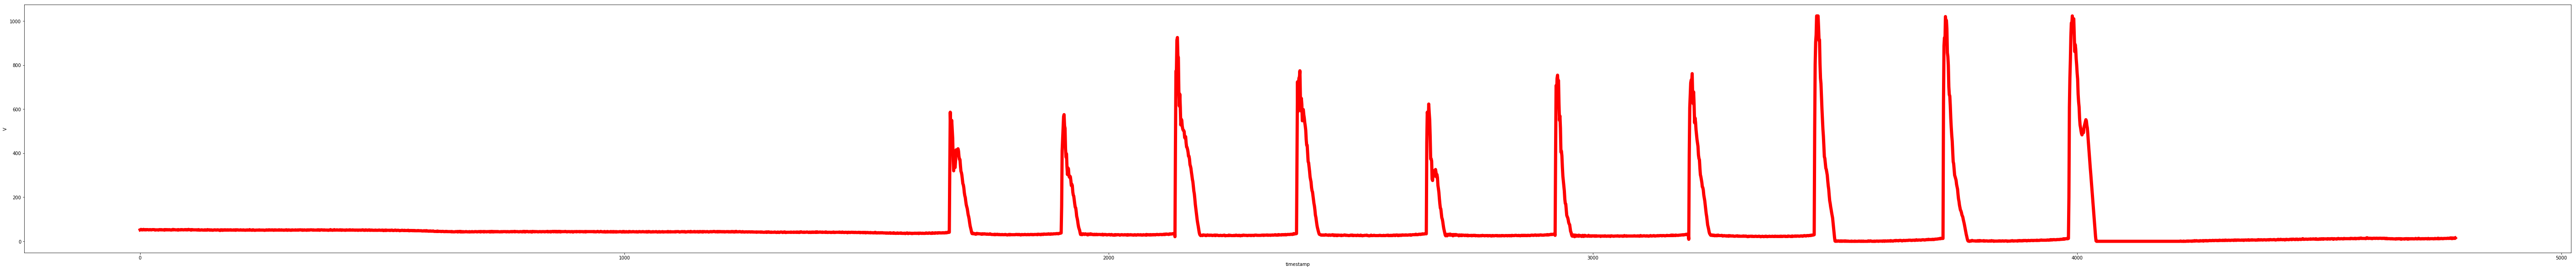

In [34]:
fig=pyplot.figure(figsize=(100,10))
pyplot.plot(sensor.astype(int), 'r',linewidth=7.0)
pyplot.xlabel('timestamp')
pyplot.ylabel('V')
pyplot.show()  
fig.savefig('raw.png')

In [35]:
#Testing sympy derivatives
def sinx(x):
    return exp(x)

def S1(u):
    x= Symbol('x')
    dFdx = (sinx(x)).diff(x)
    
    dx= lambdify((x),dFdx)

    return dx(u)

print(S1(3))

20.0855369232


## What does order of accuracy mean in this context?

The means to solve this problem was the Newton Raphson algorithm. Newton Raphson's essence is to solve a complicated equation by optimizing an expression. However, it is unknown whether the optimization of this expression is actually the solution to the problem or not. 

** Equations in the case of an anisotropic medium or cylindrical coordinates **


In the case of an anisotropic medium, the time delay would not be linear. This means that the shear waves would split. These equation must be then solved in two steps: one step to solve for the nonlinear time delay of the propagating wave and another one to solve for the triangularization. 

In the case of a spherical/cylindrical coordinate system, one can either approximate the solution as if they were a flat plate by sacrificing accuracy or one can also use FEM in order to discretize the grid in a manner that it can be later assembled in a way the solutions are in the corresponding symmetry of the problem. 

** Eikonal Equation **

For anisotropic media, the time delay problem can be also interpreted as a shortest path problem through the Eikonal Equation, which takes the form of:

\begin{equation}
|\nabla u|= \frac{1}{f(x)}
\end{equation}

http://iopscience.iop.org.colorado.idm.oclc.org/article/10.1209/0295-5075/9/6/003/pdf

where $f(x)$ is a function that involves the wave speed.

The weak form for this equation is simple, but the right hand side has to be a term that involves the wave speed in that material. If we make a manufactured solution to that equation and solve it using the FD2D notebook's solution, we are left with two different solutions for when the gradient gives a positive value and when the gradient gives a negative value or we can just use abs() after computing the gradient. Either way makes use of that solution in the notebook.

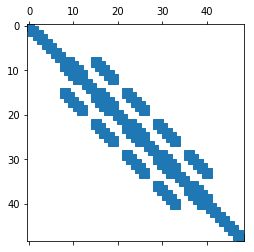

In [14]:
############################
#   BORROWED FROM FD2D     #
############################

def laplacian2dEikonal(h, f, g0):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = np.linspace(-1, 11, m)
    y, x = np.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = 1/f(x, y).flatten()
    A = sp.lil_matrix((m*m, m*m))
    def idx(i, j):
        return i*m + j
    mask = np.zeros_like(x, dtype=int)
    mask[1:-1,1:-1] = 1
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = np.array([idx(*pair) for pair in 
                                    [(i-1, j), (i, j-1),
                                     (i, j),
                                     (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * np.array([-1, -1, 4, -1, -1])
            if mask[row] == 0: # Dirichlet boundary
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                cols = stencili[smask == 1]
                A[row, cols] = stencilw[smask == 1]
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    return x, y, A.tocsr(), rhs

x, y, A, rhs = laplacian2dEikonal(.15, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);
sp.linalg.norm(A - A.T)
pyplot.show()

(51, 51) 33.7162304931


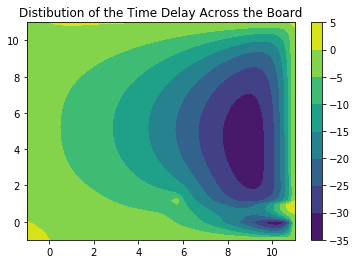

In [16]:
class mms0:
    def u(x, y):
        return x*np.exp(-x)*np.tanh(y)
    def grad_u(x, y):
        return np.array([(1 - x)*np.exp(-x)*np.tanh(y),
                            x*np.exp(-x)*(1 - np.tanh(y)**2)])
    def laplacian_u(x, y):
        return ((2 - x)*np.exp(-x)*np.tanh(y)
                - 2*x*np.exp(-x)*(np.tanh(y)**2 - 1)*np.tanh(y))
    def grad_u_dot_normal(x, y, n):
        return grad_u(x, y) @ n

x, y, A, rhs = laplacian2dEikonal(.02, mms0.laplacian_u, mms0.u)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
print(u.shape, np.linalg.norm((u - mms0.u(x,y)).flatten(), np.inf))
pyplot.contourf(x, y, u)
pyplot.colorbar()
pyplot.title('Distibution of the Time Delay Across the Board')
#pyplot.figure()
#pyplot.contourf(x, y, u - mms0.u(x, y))
#pyplot.colorbar()
#pyplot.title('Error');
pyplot.show()